## Dataset preprocessing



In [1]:
# Less noisy output
import warnings
warnings.filterwarnings('ignore')


# Numpy
import numpy as np

# XGBoost
import xgboost as xgb

# Pandas
import pandas as pd

# Sklearn
import sklearn.preprocessing
import sklearn.utils
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split


import itertools
import datetime
from datetime import date
import holidays

# Visualiseerimine
import matplotlib.pyplot as plt
%matplotlib inline

In [596]:
from google.colab import files
files.upload()

{}

In [354]:
# check if exists
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Dec  6 07:16 kaggle.json


In [355]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [356]:
!kaggle competitions download -c predict-electricity-consumption

predict-electricity-consumption.zip: Skipping, found more recently modified local copy (use --force to force download)


In [357]:
!unzip predict-electricity-consumption.zip

Archive:  predict-electricity-consumption.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
def add_interest_rate(dataset):
    ir_2021 = [0.2,0.6,1.1,1.9,3.6,3.8,5,5,6.6,7,8.8,12.2]
    ir_2022 = [11.3,12.0,15.2,18.8,20.0,21.9,22.8,24.8,23.7,22.5,None,None]
    inflation_rate = {2021:ir_2021, 2022:ir_2022}
    dataset['inflation'] = dataset.apply(lambda row: inflation_rate[row['year']][row['month']-1], axis=1)
    dataset['inflation'] = dataset['inflation'].astype(float)
    return dataset

In [3]:
def add_history(dataset):
  nr_ex_feat = 3
  for i in range(1,nr_ex_feat+1):
      # Hour step size
      i*=1
      dataset['el_price-'+str(i)] = dataset['el_price'].shift(i)
      dataset['el_price-'+str(i)] = dataset['el_price-'+str(i)].fillna(dataset['el_price'].iloc[0])
      

### Timestamp extraction

Because crazy things happened in the past year,  we validated that, some specific dates had significantly higher electricity prices. Therefore we do weekday, month, and time extraction from the timestamp.  



In [4]:
def extract_time(dataset):
    #https://www.pluralsight.com/guides/machine-learning-for-time-series-data-in-python
    dataset.loc[:,'time'] = pd.to_datetime(dataset.loc[:,'time'], format="%Y-%m-%d %H:%M:%S", utc=True)
    dataset['date'] = dataset['time'].dt.date
    dataset['hour'] = dataset['time'].dt.hour

    dataset['year'] = pd.DatetimeIndex(dataset['date']).year
    dataset['month'] = pd.DatetimeIndex(dataset['date']).month
    dataset['day'] = pd.DatetimeIndex(dataset['date']).day
    #dataset['dayofyear'] = pd.DatetimeIndex(dataset['date']).dayofyear
    #dataset['weekofyear'] = pd.DatetimeIndex(dataset['date']).weekofyear
    dataset['weekday'] = pd.DatetimeIndex(dataset['date']).weekday
    dataset['quarter'] = pd.DatetimeIndex(dataset['date']).quarter
    dataset['is_month_start'] = pd.DatetimeIndex(dataset['date']).is_month_start
    dataset['is_month_end'] = pd.DatetimeIndex(dataset['date']).is_month_end

In [5]:
def extract_holidays(dataset):
    ee_holidays = holidays.Estonia()
    dataset['holiday'] = dataset['date'].apply(lambda datex: 1 if datex in ee_holidays else 0)
    dataset['holiday'] = dataset['holiday'].astype(bool)

In [6]:
def extract_features(dataset):
    extract_time(dataset)
    add_interest_rate(dataset)
    extract_holidays(dataset)
    add_history(dataset)


### Feature dropping

In Estonia, there are approximately 500\-800 millimeters of rain on average. Our dataset consisted of only about 140mm of rain, which is definitely not correct. Also, the amount of snow was inappropriate for the  
 same reason.


In [7]:
def drop_features(dataset):
    dataset.drop(columns=['time','date','year'], inplace=True) #'prcp',


In [8]:
def replace_nan(dataset):
    if 'snow' in dataset.columns:
      dataset['snow'] = dataset['snow'].fillna(0)
    #if 'coco' in dataset.columns:
    #  dataset['coco'] = dataset['coco'].fillna(2)

In [9]:
def drop_rows(dataset):
    # Deal with NaN values
    
    replace_nan(dataset)

    initial_len = len(dataset)
    dataset.dropna(inplace=True)
    new_len = len(dataset)
    if False and (initial_len != new_len):
        print(f'Dropped {initial_len - new_len} row')

    # Deal with outliners
    if 'el_price' in dataset.columns:
      dataset.drop(dataset[dataset['el_price'] > 1].index , inplace=True)

In [10]:
def preprocess(dataset,drop_nan=True):
    extract_features(dataset)
    drop_features(dataset)
    if drop_nan:
      drop_rows(dataset)


### Import dataset

Here we import dataset, do inital processing and split into train and validation.

In [11]:
def read_dataset(file_name) -> pd.DataFrame:
    return pd.read_csv(file_name)

In [12]:
def extract_labels(dataset) -> (pd.DataFrame, pd.Series):
    X_train = dataset.loc[:, ~dataset.columns.isin(['consumption'])]
    y_train = dataset['consumption']
    return (X_train, y_train)

In [13]:
train_o_df = read_dataset('train.csv')

In [14]:
train_df = train_o_df.copy()
preprocess(train_df)

In [15]:
def get_labels(labels, bits):
  chosen_labels=[]
  bits = bin(bits)[2:][::-1]
  for i, b in enumerate(bits):
    if b == '1':
      chosen_labels.append(labels[i])

  return chosen_labels

In [16]:
train_df.shape

(1962, 24)

In [17]:
xgbr = None
from sklearn.model_selection import cross_validate
seed = np.random.randint(0,1000000)
print(f'seed: {seed}')
labels_scores = []

train_df = train_o_df.copy()
preprocess(train_df,False)
print(f"nr columns: {len(train_df.columns)}")
visited = []
print('_')

for i in range(1000):
  for _ in range(len(str(i-1))):
    print('\b',end='')
  print(i,end='')
  labels_chosen_b = np.random.randint(1,2**len(train_df.columns))
  while labels_chosen_b in visited:
    labels_chosen_b = np.random.randint(1,2**len(train_df.columns))
  visited.append(labels_chosen_b)
  i_labels = ['consumption'] + get_labels(train_df.columns,labels_chosen_b)

  i_df=train_df.copy()[i_labels]
  drop_rows(i_df)
  X_train, y_train = extract_labels(i_df)

  np.random.seed(seed) # random seed for consistency
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)


  xgbr = xgb.XGBRegressor(verbosity=0)

  scores = cross_validate(xgbr,X_train, y_train, cv=4,
                          scoring=('r2', 'neg_mean_absolute_error'),
                          return_train_score=True)
  train_mae = scores['train_neg_mean_absolute_error'].mean()
  test_mae = scores['test_neg_mean_absolute_error'].mean()
  if np.isnan(train_mae) or np.isnan(test_mae):
    continue
  labels_scores.append((i_labels,train_mae,test_mae))
  if False:
      print(f"train: {train_mae}")
      print(f"test: {test_mae}")
      print()

seed: 259142
nr columns: 24
_
0123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130131132133134135136137138139140141142143144145146147148149150151152153154155156157158159160161162163164165166167168169170171172173174175176177178179180181182183184185186187188189190191192193194195196197

In [18]:
labels_scores = sorted(labels_scores,key=lambda val: val[2],reverse=True)
for labels,train_score,test_score in labels_scores[:3]:
    print(labels)
    print('\t',train_score)
    print('\t',test_score)
print()
labels_scores = sorted(labels_scores,key=lambda val: val[1],reverse=True)
for labels,train_score,test_score in labels_scores[:3]:
    print(labels)
    print('\t',train_score)
    print('\t',test_score)

['consumption', 'dwpt', 'prcp', 'snow', 'el_price', 'hour', 'quarter', 'is_month_end', 'inflation', 'holiday']
	 -0.3310735021869876
	 -0.3772560956494724
['consumption', 'temp', 'dwpt', 'rhum', 'prcp', 'pres', 'el_price', 'hour', 'month', 'weekday', 'is_month_end', 'inflation', 'holiday', 'el_price-1']
	 -0.3166449833831073
	 -0.38043465214217353
['consumption', 'temp', 'dwpt', 'rhum', 'prcp', 'wspd', 'pres', 'hour', 'month', 'day', 'weekday', 'quarter', 'inflation', 'holiday']
	 -0.322060229279985
	 -0.38046292786337577

['consumption', 'temp', 'dwpt', 'rhum', 'prcp', 'pres', 'el_price', 'hour', 'month', 'weekday', 'is_month_end', 'inflation', 'holiday', 'el_price-1']
	 -0.3166449833831073
	 -0.38043465214217353
['consumption', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wpgt', 'el_price', 'hour', 'month', 'day', 'is_month_end', 'inflation', 'el_price-1', 'el_price-2', 'el_price-3']
	 -0.3167718450095055
	 -0.38692269703206916
['consumption', 'temp', 'dwpt', 'rhum', 'prcp', 'wdi

In [19]:
best_labels = sorted(labels_scores,key=lambda val: val[2],reverse=True)[1][0]
best_labels

['consumption',
 'temp',
 'dwpt',
 'rhum',
 'prcp',
 'pres',
 'el_price',
 'hour',
 'month',
 'weekday',
 'is_month_end',
 'inflation',
 'holiday',
 'el_price-1']

In [43]:
!pip install evolutionary_algorithm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 44 kB 2.1 MB/s 
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15096 sha256=1c20be2eb1765d326eee4efda04db1d1c0675a0f79d133913e1d60764112dc10
  Stored in directory: /root/.cache/pip/wheels/a8/92/ca/5bbab358275e310af23b73fc32ebf37d6a7a08c87c8d2cdbc1
Successfully built func-timeout


In [ ]:
from evolutionary_algorithm import EvolutionaryAlgorithm as ea
seed = np.random.randint(0,1000000)
print(f'seed: {seed}')

# Declare objective function parameters and bounds
objective_parameters = [
    {'name' : 'labels_choise',
     'bounds' : [1,2**len(train_df.columns)],
     'type' : 'int'}
]


# Define the objective function (with embedded predictive model)
def objective_function(args):
    i_labels = ['consumption'] + get_labels(train_df.columns,args['labels_choise'])
    
    i_df=train_df.copy()[i_labels]
    drop_rows(i_df)
    X_train, y_train = extract_labels(i_df)
    np.random.seed(seed) # random seed for consistency
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    
    xgbr = xgb.XGBRegressor(verbosity=0)

    scores = cross_validate(xgbr,X_train, y_train, cv=4,
                          scoring=('r2', 'neg_mean_absolute_error'),
                          return_train_score=True)
    train_mae = scores['train_neg_mean_absolute_error'].mean()
    test_mae = scores['test_neg_mean_absolute_error'].mean()
    if np.isnan(train_mae) or np.isnan(test_mae):
      return np.inf
    return test_mae * -1 # Expects a value to be minimized

# Create instance of EA object
evo_algo = ea(function=objective_function,parameters=objective_parameters,function_timeout=1200,
              algorithm_parameters={'max_num_iteration': 10000,
                                       'population_size': 100,
                                       'mutation_probability': 0.1,
                                       'elite_ratio': 0.05,
                                       'crossover_probability': 0.5,
                                       'parents_portion': 0.3,
                                       'crossover_type': 'uniform',
                                       'max_iteration_without_improv': 8000}
              )

# Run EA
evo_algo.run()

# Access best model parameters
evo_algo.best_parameters

seed: 273924


  4%|▍         | 428/10000 [10:03<3:42:35,  1.40s/it]

seed: 307356
 80%|████████  | 8001/10000 [1:26:37<21:38,  1.54it/s]Best parameters found: {'labels_choise': 1740}
Best objective output = 0.38507842898660377
Terminating algorithm: Exceeded maximum iterations without improvement.
{'labels_choise': 1740}

In [56]:
get_labels(train_df.columns,1740)

['dwpt', 'rhum', 'el_price', 'hour', 'weekday', 'is_month_end']

In [60]:
best_labels = ['consumption']+['dwpt', 'rhum', 'el_price', 'hour', 'weekday', 'is_month_end']#1740

In [61]:
train_df = train_o_df.copy()
preprocess(train_df,False)
train_df = train_df[best_labels]
drop_rows(train_df)

In [62]:
X_train.shape

(1726, 13)

In [63]:
X_train, y_train = extract_labels(train_df)
seed = np.random.randint(0,1000000)
print(f'seed: {seed}')#438646 #349673 0.24,0.36
np.random.seed(438646)#seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

seed: 198347


In [64]:
xgbr = xgb.XGBRegressor(verbosity=0)

In [65]:
xgbr.fit(X_train, y_train)

XGBRegressor(verbosity=0)

In [66]:
yvalpred = xgbr.predict(X_val)
mse = mean_squared_error(y_val, yvalpred)
mae = mean_absolute_error(y_val, yvalpred)
print("MSE: %.2f" % mse)
print("MAE: %.2f" % mae)

MSE: 0.83
MAE: 0.53


In [27]:
X_test = read_dataset('test.csv')
preprocess(X_test,False)
X_test = X_test[best_labels[1:]]
drop_rows(X_test)
print(X_test.shape)

(168, 13)


In [28]:
prediction = xgbr.predict(X_test)

In [29]:
prediction

array([0.35923773, 0.30465046, 0.30465046, 0.23914728, 0.6610995 ,
       0.33195764, 0.33195764, 0.34776127, 0.59482884, 0.5400699 ,
       0.55899405, 0.6378248 , 0.565236  , 0.565236  , 0.65729904,
       0.72005177, 0.74302876, 0.827031  , 0.79249966, 0.75065017,
       0.74363124, 1.1658044 , 1.1481931 , 0.4142827 , 0.38296962,
       0.3403178 , 0.23644212, 0.21651718, 0.70103234, 0.30168012,
       0.41438717, 0.36060944, 0.62656206, 0.64225245, 0.7146446 ,
       0.7206389 , 0.6989223 , 0.6989223 , 0.6504559 , 0.707194  ,
       0.79869664, 0.9555151 , 0.83565354, 0.79380417, 0.88550884,
       0.7632636 , 0.66953444, 0.3522637 , 0.30604792, 0.21669024,
       0.3205077 , 0.18962827, 0.63180697, 0.40173152, 0.380971  ,
       0.31204796, 0.573099  , 0.5819948 , 0.6550835 , 0.6520643 ,
       0.8016983 , 0.7902645 , 0.8640501 , 0.82796043, 0.9507224 ,
       1.1239326 , 1.1080414 , 1.1333292 , 1.0943861 , 0.8971059 ,
       0.6921437 , 0.37811157, 0.3979941 , 0.3540746 , 0.32732

In [30]:
X_test = read_dataset('test.csv')

In [31]:
predictions_dict = {'time':X_test.time,'consumption':prediction}
pred_df = pd.DataFrame(predictions_dict)

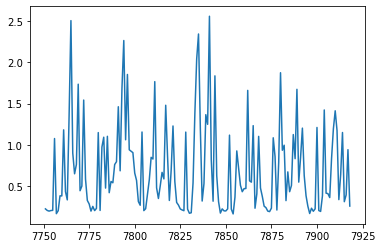

In [41]:
i=5
step = 168
train_df.iloc[-step*i:-step*(i-1)].consumption.plot()

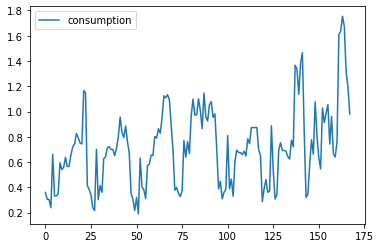

In [32]:
pred_df.plot()

In [923]:
pred_df.to_csv('submission_Xgboost_6_13_52.csv',index=False)

In [924]:
!ls

 est_mean_h_prcp.csv		       submission_Xgboost_6_12_03.csv
'kaggle (1).json'		       submission_Xgboost_6_13_52.csv
 kaggle.json			       submission_Xgboost_v4.csv
 predict-electricity-consumption.zip   submission_Xgboost_v9.csv
 sample_data			       test.csv
 sample_submission.csv		       train.csv
 submission_Xgboost_6_11_40.csv


In [925]:
!kaggle competitions submit predict-electricity-consumption -f 'submission_Xgboost_6_13_52.csv' -m "random tuning"

100% 5.99k/5.99k [00:03<00:00, 1.61kB/s]
Successfully submitted to Journey to zero - Predict electricity consumption